In [8]:
#versão da Linguagem Python
from platform import python_version
print('Versão da linguagem Python usada no ambiente virtual desse projeto:', python_version())

Versão da linguagem Python usada no ambiente virtual desse projeto: 3.12.7


In [1]:
# --- 1. CONFIGURAÇÃO DO AMBIENTE ---

from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
import os
import sys
from statsmodels.tsa.api import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import display, HTML
from matplotlib.ticker import FuncFormatter

# Configurações de visualização para os gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (18, 7)
plt.rcParams['font.size'] = 12

In [2]:
df = pd.read_csv(r"C:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\data\processed\casos_area_criminal.csv",sep=',')
df.head()
df.shape

(1073850, 13)

In [3]:
# 1.3. Visualização das primeiras linhas
print("📊 5 PRIMEIRAS LINHAS DO DATASET")
print("=" * 50)
display(HTML("<h4 style='color: #2E86AB;'>🔍 Visualização Inicial - Primeiros Registros</h4>"))
display(df.head().style.set_caption("Tabela 1: Primeiras 5 entradas do dataset"))

# 1.4. Visualização das últimas linhas para garantir a integridade
print("\n" + "=" * 60)
print("📊 5 ÚLTIMAS LINHAS DO DATASET")
print("=" * 50)
display(HTML("<h4 style='color: #2E86AB;'>🔍 Verificação de Integridade - Últimos Registros</h4>"))
display(df.tail().style.set_caption("Tabela 2: Últimas 5 entradas do dataset"))

# Informações adicionais sobre o dataset
print("\n" + "=" * 60)
print("📈 METADADOS DO DATASET")
print("=" * 50)

print(f"• Dimensões do dataset: {df.shape[0]} linhas × {df.shape[1]} colunas")
print(f"• Período abrangido: {df['DATA_RECEBIMENTO'].min()} até {df['DATA_RECEBIMENTO'].max()}" 
      if 'DATA_RECEBIMENTO' in df.columns else "• Coluna de data não disponível")

# Visualização rápida dos tipos de dados
print("\n📝 TIPOS DE DADOS POR COLUNA:")
print("-" * 35)
for col, dtype in df.dtypes.items():
    print(f"• {col:<20}: {str(dtype):<15}")

📊 5 PRIMEIRAS LINHAS DO DATASET


,NUMERO,ASSUNTOS,DATA_RECEBIMENTO,PRIORIDADE,SEGREDO_JUSTICA,SERVENTIA,COMARCA,CLASSE,PROC_STATUS,AREA_ACAO,VALOR_CAUSA,CNJ_ASSUNTO,PROJUDI_ASSUNTO
0,0000000-00.0000.8.09.0139,7942,2014-09-16,Normal,nan,Rubiataba - Execução Penal/EXECPENWEB,RUBIATABA,nan,Arquivado,Criminal,nan,['Execução Penal e de Medidas Alternativas'],['DIREITO PROCESSUAL PENAL -> Execução Penal e de Medidas Alternativas']
1,0000000-00.0000.8.09.0156,7942,2014-04-23,Normal,nan,Varjão - Execução Penal/EXECPENWEB,VARJÃO,nan,Arquivado,Criminal,nan,['Execução Penal e de Medidas Alternativas'],['DIREITO PROCESSUAL PENAL -> Execução Penal e de Medidas Alternativas']
2,0000000-00.0000.8.09.0484,7942,2019-05-22,Normal,nan,Petrolina de Goiás - Execução Penal/EXECPENWEB,PETROLINA DE GOIÁS,nan,Arquivado,Criminal,nan,['Execução Penal e de Medidas Alternativas'],['DIREITO PROCESSUAL PENAL -> Execução Penal e de Medidas Alternativas']
3,0000000-00.0002.8.09.0132,7942,2016-08-06,Normal,nan,Posse - Execução Penal/EXECPENWEB,POSSE,nan,Cálculo,Criminal,nan,['Execução Penal e de Medidas Alternativas'],['DIREITO PROCESSUAL PENAL -> Execução Penal e de Medidas Alternativas']
4,0000000-00.0002.8.09.0139,7942,2014-06-26,Normal,nan,Rubiataba - Execução Penal/EXECPENWEB,RUBIATABA,nan,Cálculo,Criminal,nan,['Execução Penal e de Medidas Alternativas'],['DIREITO PROCESSUAL PENAL -> Execução Penal e de Medidas Alternativas']



📊 5 ÚLTIMAS LINHAS DO DATASET


,NUMERO,ASSUNTOS,DATA_RECEBIMENTO,PRIORIDADE,SEGREDO_JUSTICA,SERVENTIA,COMARCA,CLASSE,PROC_STATUS,AREA_ACAO,VALOR_CAUSA,CNJ_ASSUNTO,PROJUDI_ASSUNTO
1073845,9960921-82.2009.8.09.0006,7785,2016-04-29,Normal,nan,Anápolis - Execução Penal/EXECPENWEB,ANÁPOLIS,386.000000,Arquivado,Criminal,nan,['Prestação Pecuniária'],['DIREITO PROCESSUAL PENAL -> Execução Penal e de Medidas Alternativas -> Pena Restritiva de Direitos -> Prestação Pecuniária']
1073846,9960922-16.2009.8.09.0120,7942,2016-11-24,Normal,nan,Paraúna - Execução Penal/EXECPENWEB,PARAÚNA,nan,Cálculo,Criminal,nan,['Execução Penal e de Medidas Alternativas'],['DIREITO PROCESSUAL PENAL -> Execução Penal e de Medidas Alternativas']
1073847,9960936-10.2009.8.09.0149,7942,2016-04-15,Normal,nan,Trindade - Execução Penal/EXECPENWEB,TRINDADE,nan,Arquivado,Criminal,nan,['Execução Penal e de Medidas Alternativas'],['DIREITO PROCESSUAL PENAL -> Execução Penal e de Medidas Alternativas']
1073848,9960954-04.2009.8.09.0158,7942,2014-06-25,Normal,nan,Santo Antônio do Descoberto - Execução Penal/EXECPENWEB,SANTO ANTÔNIO DO DESCOBERTO,nan,Cálculo,Criminal,nan,['Execução Penal e de Medidas Alternativas'],['DIREITO PROCESSUAL PENAL -> Execução Penal e de Medidas Alternativas']
1073849,9968170-70.2017.8.09.0017,3492,2017-11-04,Normal,nan,Bela Vista de Goiás - Vara Criminal,BELA VISTA DE GOIÁS,283.000000,Arquivado,Criminal,nan,['Incêndio'],['DIREITO PENAL -> Crimes contra a Incolumidade Pública -> Incêndio']



📈 METADADOS DO DATASET
• Dimensões do dataset: 1073850 linhas × 13 colunas
• Período abrangido: 2014-01-02 até 2023-12-31

📝 TIPOS DE DADOS POR COLUNA:
-----------------------------------
• NUMERO              : object         
• ASSUNTOS            : object         
• DATA_RECEBIMENTO    : object         
• PRIORIDADE          : object         
• SEGREDO_JUSTICA     : float64        
• SERVENTIA           : object         
• COMARCA             : object         
• CLASSE              : float64        
• PROC_STATUS         : object         
• AREA_ACAO           : object         
• VALOR_CAUSA         : float64        
• CNJ_ASSUNTO         : object         
• PROJUDI_ASSUNTO     : object         


# Dicionário de Dados do Sistema Processual

| Campo | Tipo | Descrição | Observações |
|:------|:-----|:----------|:------------|
| **NUMERO** | Identificador único | Identificador único do processo | Chave primária do sistema |
| **DATA_RECEBIMENTO** | Data | Data em que o processo foi protocolado/recebido | **Variável alvo para a série temporal** |
| **PRIORIDADE** | Categórico | Indica se o processo tem prioridade de tramitação | Valores: [Sim, Não] |
| **SEGREDO_JUSTICA** | Booleano | Indica se o processo corre em segredo de justiça | Valores: [True, False] |
| **SERVENTIA** | Categórico | Unidade judiciária responsável (Vara, Cartório) | Alta cardinalidade |
| **COMARCA** | Categórico | Unidade territorial judiciária | Alta cardinalidade |
| **CLASSE** | Numérico (atual) | Código ou nome da classe processual | Atualmente como float, precisa de investigação |
| **ASSUNTOS** | Categórico | Tema(s) legal(is) tratados no processo | Pode conter múltiplos valores |
| **PROC_STATUS** | Categórico | Status atual do processo | Ex: Ativo, Arquivado, etc. |
| **AREA_ACAO** | Categórico | Área do direito | - |
| **VALOR_CAUSA** | Numérico | Valor monetário atribuído à causa | - |

In [4]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

print("🔍 CONTAGEM DE VALORES AUSENTES POR COLUNA")
print("=" * 50)

# 2.1. Valores ausentes
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Valores Ausentes': missing_values, 
    'Percentual (%)': missing_percentage.round(2)
})

missing_data = missing_df[missing_df['Valores Ausentes'] > 0].sort_values(
    by='Valores Ausentes', ascending=False
)

if not missing_data.empty:
    print("Tabela 1: Valores Ausentes no Dataset")
    print("-" * 50)
    for idx, row in missing_data.iterrows():
        percent = row['Percentual (%)']
        if percent > 10:
            color_code = "\033[91m"  # Vermelho
        elif percent > 5:
            color_code = "\033[93m"  # Amarelo
        else:
            color_code = "\033[33m"  # Laranja
        reset_code = "\033[0m"
        print(f"{idx:<20} | {row['Valores Ausentes']:<16} | {color_code}{percent:.2f}%{reset_code}")
    print("-" * 50)
else:
    print("✅ Nenhum valor ausente encontrado no dataset!")

# 2.2. Verificação de registros duplicados
print("\n" + "=" * 60)
num_duplicates = df.duplicated().sum()
if num_duplicates > 0:
    print(f"⚠️  ALERTA: {num_duplicates} linhas completamente duplicadas encontradas!")
else:
    print("✅ Nenhum registro duplicado encontrado!")

# 2.3. Investigação inicial da coluna AREA_ACAO
print("\n" + "=" * 60)
print("🔎 INVESTIGAÇÃO DA COLUNA 'AREA_ACAO'")

if 'AREA_ACAO' in df.columns:
    unique_areas = df['AREA_ACAO'].nunique()
    print(f"Número de valores únicos na coluna AREA_ACAO: {unique_areas}")

    area_distribution = df['AREA_ACAO'].value_counts()
    area_table = pd.DataFrame({
        'Área de Ação': area_distribution.index,
        'Contagem': area_distribution.values,
        'Percentual (%)': (area_distribution.values / len(df) * 100).round(2)
    })

    display(HTML("<h4 style='color: #2E86AB;'>📊 Distribuição da Área de Ação </h4>"))
    display(area_table)

    print(f"\n💡 Informações adicionais:")
    print(f"   • Tipo de dados: {df['AREA_ACAO'].dtype}")
    print(f"   • Valores nulos: {df['AREA_ACAO'].isnull().sum()}")
    print(f"   • Valor mais frequente: {area_distribution.index[0]} "
          f"({area_distribution.values[0]} ocorrências)")

else:
    print("❌ Coluna 'AREA_ACAO' não encontrada no DataFrame")

# 2.4. Verificação da coluna DATA_RECEBIMENTO
print("\n" + "=" * 60)
print("📅 VERIFICAÇÃO DA COLUNA DATA_RECEBIMENTO")
if 'DATA_RECEBIMENTO' in df.columns:
    print(f"Tipo atual da coluna: {df['DATA_RECEBIMENTO'].dtype}")
    print(f"Exemplo de valores: {df['DATA_RECEBIMENTO'].head(3).tolist()}")

    null_count = df['DATA_RECEBIMENTO'].isnull().sum()
    if null_count > 0:
        print(f"⚠️  ALERTA: {null_count} valores nulos encontrados na coluna DATA_RECEBIMENTO")
    else:
        print("✅ Nenhum valor nulo na coluna DATA_RECEBIMENTO")
else:
    print("❌ Coluna 'DATA_RECEBIMENTO' não encontrada")


🔍 CONTAGEM DE VALORES AUSENTES POR COLUNA
Tabela 1: Valores Ausentes no Dataset
--------------------------------------------------
SEGREDO_JUSTICA      | 1073850.0        | 100.00%
VALOR_CAUSA          | 875024.0         | 81.48%
CLASSE               | 36714.0          | 3.42%
--------------------------------------------------

✅ Nenhum registro duplicado encontrado!

🔎 INVESTIGAÇÃO DA COLUNA 'AREA_ACAO'
Número de valores únicos na coluna AREA_ACAO: 1


,Área de Ação,Contagem,Percentual (%)
0,Criminal,1073850,100.0



💡 Informações adicionais:
   • Tipo de dados: object
   • Valores nulos: 0
   • Valor mais frequente: Criminal (1073850 ocorrências)

📅 VERIFICAÇÃO DA COLUNA DATA_RECEBIMENTO
Tipo atual da coluna: object
Exemplo de valores: ['2014-09-16', '2014-04-23', '2019-05-22']
✅ Nenhum valor nulo na coluna DATA_RECEBIMENTO


🚀 INICIANDO ANÁLISE DE SEGMENTOS

🎯 ============================================================
📈 ANÁLISE DA COLUNA: 'COMARCA
🎯 ============================================================
🔢 Número de categorias únicas: 119
📊 As 30 categorias principais representam 75.84% de todos os casos.


C:\Users\mlzengo\AppData\Local\Temp\ipykernel_22740\549670622.py:77: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


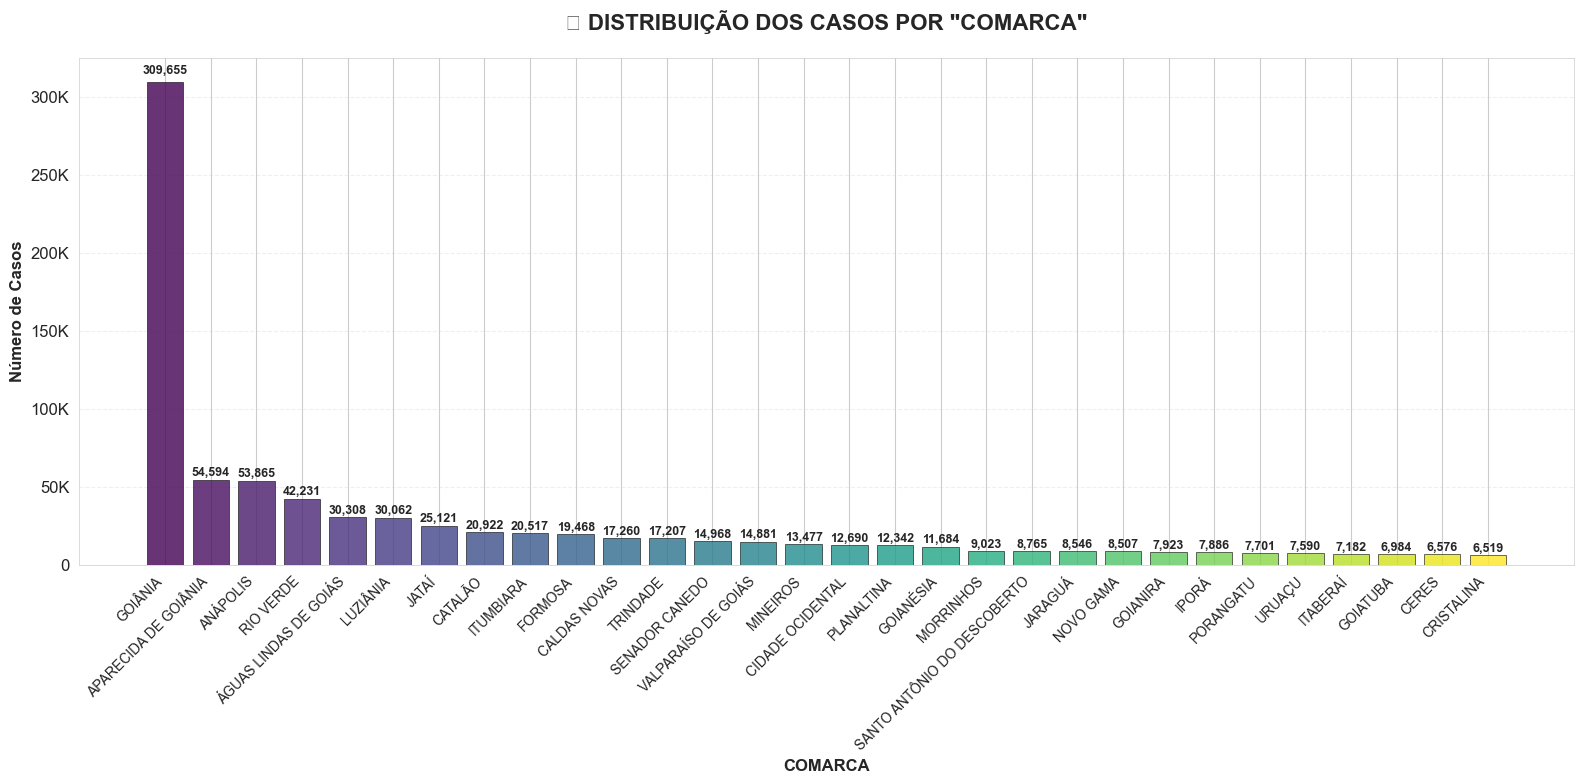

,Categoria,Contagem,Percentual (%)
0,GOIÂNIA,309655,28.84
1,APARECIDA DE GOIÂNIA,54594,5.08
2,ANÁPOLIS,53865,5.02
3,RIO VERDE,42231,3.93
4,ÁGUAS LINDAS DE GOIÁS,30308,2.82
5,LUZIÂNIA,30062,2.80
6,JATAÍ,25121,2.34
7,CATALÃO,20922,1.95
8,ITUMBIARA,20517,1.91
9,FORMOSA,19468,1.81



💡 RESUMO ESTATÍSTICO:
   • Categoria mais frequente: 'GOIÂNIA' (309,655 casos)
   • Representatividade da categoria principal: 28.84%

📋 LISTA DE COLUNAS CATEGÓRICAS DISPONÍVEIS PARA ANÁLISE:
1. PRIORIDADE
2. SEGREDO_JUSTICA
3. SERVENTIA
4. CLASSE
5. ASSUNTOS
6. PROC_STATUS
7. AREA_ACAO


In [5]:
def analisar_segmento(df, coluna, top_n=30):
    """
    📊 Função para analisar e visualizar a distribuição de uma coluna categórica.
    
    Parâmetros:
    -----------
    df : DataFrame
        DataFrame contendo os dados
    coluna : str
        Nome da coluna categórica a ser analisada
    top_n : int, opcional (padrão=15)
        Número de categorias principais a serem visualizadas
    """
    print(f"\n🎯 {'='*60}")
    print(f"📈 ANÁLISE DA COLUNA: '{coluna.upper()}")
    print(f"🎯 {'='*60}")
    
    # Verificar se a coluna existe
    if coluna not in df.columns:
        print(f"❌ ERRO: Coluna '{coluna}' não encontrada no DataFrame!")
        return None
    
    # Quantidade de valores únicos
    num_unicos = df[coluna].nunique()
    print(f"🔢 Número de categorias únicas: {num_unicos}")
    
    # Verificar valores nulos
    nulos = df[coluna].isnull().sum()
    if nulos > 0:
        print(f"⚠️  Valores nulos: {nulos} ({nulos/len(df)*100:.2f}%)")
    
    # Contagem das categorias mais frequentes
    contagem = df[coluna].value_counts()
    
    # Porcentagem do total representada pelas Top N categorias
    porc_top_n = (contagem.head(top_n).sum() / len(df)) * 100
    print(f"📊 As {top_n} categorias principais representam {porc_top_n:.2f}% de todos os casos.")
    
    # Visualização com estilo aprimorado
    plt.figure(figsize=(16, 8))
    
    # Criar paleta de cores vibrantes
    cores = plt.cm.viridis(np.linspace(0, 1, top_n))
    
    # Criar gráfico de barras
    bars = plt.bar(range(top_n), contagem.head(top_n).values, color=cores, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Personalizar título e rótulos
    plt.title(f'📋 DISTRIBUIÇÃO DOS CASOS POR "{coluna.upper()}"', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Número de Casos', fontsize=12, fontweight='bold')
    plt.xlabel(coluna, fontsize=12, fontweight='bold')
    
    # Rotacionar labels para melhor visualização
    plt.xticks(range(top_n), contagem.head(top_n).index, rotation=45, ha='right', fontsize=10)
    
    # Adicionar valores nas barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Adicionar grid para melhor legibilidade
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Formatar eixo Y para valores grandes
    def formatar_valores(x, pos):
        if x >= 1_000_000:
            return f'{x/1_000_000:.1f}M'
        elif x >= 1_000:
            return f'{x/1_000:.0f}K'
        else:
            return f'{int(x)}'
    
    plt.gca().yaxis.set_major_formatter(FuncFormatter(formatar_valores))
    
    # Ajustar layout
    plt.tight_layout()
    
    # Adicionar borda ao gráfico
    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.5)
    
    plt.show()
    
    # Exibir tabela com as top categorias
    display(HTML(f"<h4 style='color: #2E86AB;'>📋 TOP {top_n} CATEGORIAS - {coluna.upper()}</h4>"))
    
    tabela_resultados = pd.DataFrame({
        'Categoria': contagem.head(top_n).index,
        'Contagem': contagem.head(top_n).values,
        'Percentual (%)': (contagem.head(top_n).values / len(df) * 100).round(2)
    })
    
    display(tabela_resultados)
    
    print(f"\n💡 RESUMO ESTATÍSTICO:")
    print(f"   • Categoria mais frequente: '{contagem.index[0]}' ({contagem.values[0]:,} casos)")
    print(f"   • Representatividade da categoria principal: {contagem.values[0]/len(df)*100:.2f}%")
    
    return contagem

# Exemplo de uso com estilo
print("🚀 INICIANDO ANÁLISE DE SEGMENTOS")
print("=" * 60)

contagem_comarca = analisar_segmento(df, 'COMARCA')

# Análise adicional para outras colunas categóricas
colunas_interesse = ['PRIORIDADE', 'SEGREDO_JUSTICA', 'SERVENTIA', 'CLASSE', 'ASSUNTOS', 'PROC_STATUS', 'AREA_ACAO']

print(f"\n{'='*60}")
print("📋 LISTA DE COLUNAS CATEGÓRICAS DISPONÍVEIS PARA ANÁLISE:")
print("=" * 60)

for i, coluna in enumerate(colunas_interesse, 1):
    if coluna in df.columns:
        print(f"{i}. {coluna}")
    else:
        print(f"{i}. {coluna} ❌ (não encontrada)")
        

In [6]:
print("\n🎯 " + "="*60)
print("⏳ VERIFICAÇÃO DE PERIODICIDADE - DISTRIBUIÇÃO TEMPORAL")
print("🎯 " + "="*60)

if 'DATA_RECEBIMENTO' in df.columns:
    # Converter para datetime
    df['DATA_RECEBIMENTO'] = pd.to_datetime(df['DATA_RECEBIMENTO'], errors='coerce')
    
    # Calcular diferenças entre registros
    diferencas = df['DATA_RECEBIMENTO'].diff().dropna()
    
    # Verificar valores nulos após conversão
    nulos_data = df['DATA_RECEBIMENTO'].isnull().sum()
    if nulos_data > 0:
        print(f"⚠️  Valores nulos/inválidos em DATA_RECEBIMENTO: {nulos_data} ({nulos_data/len(df)*100:.2f}%)")
    
    # Análise das diferenças temporais
    print(f"📊 Total de intervalos calculados: {len(diferencas):,}")
    print(f"📅 Período abrangido: {df['DATA_RECEBIMENTO'].min().strftime('%d/%m/%Y')} a {df['DATA_RECEBIMENTO'].max().strftime('%d/%m/%Y')}")
    print(f"⏱️  Duração total: {(df['DATA_RECEBIMENTO'].max() - df['DATA_RECEBIMENTO'].min()).days} dias")
    
    # Principais intervalos
    freq = diferencas.value_counts().head(10)
    
    print(f"\n🎯 PRINCIPAIS INTERVALOS TEMPORAIS ENCONTRADOS:")
    print("-" * 50)
    
    # Criar DataFrame para exibição formatada
    freq_df = pd.DataFrame({
        'Intervalo': freq.index,
        'Frequência': freq.values,
        'Percentual (%)': (freq.values / len(diferencas) * 100).round(2)
    })
    
    # Exibir tabela formatada
    display(HTML("<h4 style='color: #2E86AB;'>⏰ DISTRIBUIÇÃO DOS INTERVALOS TEMPORAIS</h4>"))
    display(freq_df.style.format({
        'Frequência': '{:,}',
        'Percentual (%)': '{:.2f}%'
    }).set_properties(**{
        'background-color': '#f8f9fa',
        'color': '#2c3e50',
        'border-color': '#dee2e6'
    }))
    
    # Estatísticas adicionais
    print(f"\n💡 ESTATÍSTICAS DOS INTERVALOS TEMPORAIS:")
    print(f"   • Intervalo médio: {diferencas.mean()}")
    print(f"   • Intervalo mais comum: {diferencas.mode().iloc[0] if not diferencas.mode().empty else 'N/A'}")
    print(f"   • Maior intervalo: {diferencas.max()}")
    print(f"   • Menor intervalo: {diferencas.min()}")
    print(f"   • Desvio padrão: {diferencas.std()}")
    
    # Verificar padrão de regularidade
    intervalo_mais_comum = freq.index[0] if not freq.empty else None
    if intervalo_mais_comum and intervalo_mais_comum in [pd.Timedelta('1D'), pd.Timedelta('7D')]:
        print(f"✅ Padrão detectado: {'DIÁRIO' if intervalo_mais_comum == pd.Timedelta('1D') else 'SEMANAL'}")
    
else:
    print("❌ COLUNA 'DATA_RECEBIMENTO' NÃO ENCONTRADA NO DATASET!")
    print("   Verifique o nome da coluna ou se os dados possuem informações temporais.")


🎯 ============================================================
⏳ VERIFICAÇÃO DE PERIODICIDADE - DISTRIBUIÇÃO TEMPORAL
🎯 ============================================================
📊 Total de intervalos calculados: 1,073,849
📅 Período abrangido: 02/01/2014 a 31/12/2023
⏱️  Duração total: 3650 dias

🎯 PRINCIPAIS INTERVALOS TEMPORAIS ENCONTRADOS:
--------------------------------------------------


,Intervalo,Frequência,Percentual (%)
0,0 days 00:00:00,"154,617",14.40%
1,356 days 00:00:00,"2,715",0.25%
2,-356 days +00:00:00,"2,689",0.25%
3,-363 days +00:00:00,"2,650",0.25%
4,363 days 00:00:00,"2,580",0.24%
5,335 days 00:00:00,"2,499",0.23%
6,-335 days +00:00:00,"2,478",0.23%
7,357 days 00:00:00,"2,261",0.21%
8,-357 days +00:00:00,"2,230",0.21%
9,-355 days +00:00:00,"2,084",0.19%



💡 ESTATÍSTICAS DOS INTERVALOS TEMPORAIS:
   • Intervalo médio: 0 days 00:01:32.124684196
   • Intervalo mais comum: 0 days 00:00:00
   • Maior intervalo: 3611 days 00:00:00
   • Menor intervalo: -3596 days +00:00:00
   • Desvio padrão: 1198 days 13:50:51.696930032


In [7]:
print("\n🎯 " + "="*60)
print("📊 ANÁLISE TEMPORAL - DISTRIBUIÇÃO POR ANO E MÊS")
print("🎯 " + "="*60)

if 'DATA_RECEBIMENTO' in df.columns:
    # Extrair ano e mês
    df['ANO'] = df['DATA_RECEBIMENTO'].dt.year
    df['MES'] = df['DATA_RECEBIMENTO'].dt.month
    
    # Verificar dados nulos
    nulos_temporais = df['ANO'].isnull().sum()
    if nulos_temporais > 0:
        print(f"⚠️  Registros sem data válida: {nulos_temporais} ({nulos_temporais/len(df)*100:.2f}%)")
    
    # Calcular estatísticas
    casos_por_ano = df.groupby('ANO').size()
    casos_por_mes = df.groupby(['ANO', 'MES']).size()
    
    # Informações gerais
    anos_abrangidos = casos_por_ano.index.tolist()
    print(f"📅 Período analisado: {min(anos_abrangidos)} - {max(anos_abrangidos)}")
    print(f"📈 Total de anos com registros: {len(casos_por_ano)}")
    print(f"📊 Total de meses com registros: {len(casos_por_mes)}")
    
    # Análise por ano - com visualização
    print(f"\n🎯 DISTRIBUIÇÃO DE CASOS POR ANO:")
    print("-" * 50)
    
    # Criar DataFrame formatado para anos
    ano_df = pd.DataFrame({
        'Ano': casos_por_ano.index,
        'Casos': casos_por_ano.values,
        'Percentual (%)': (casos_por_ano.values / len(df) * 100).round(2),
        'Variação Anual (%)': casos_por_ano.pct_change().mul(100).round(2)
    })
    
    display(HTML("<h4 style='color: #2E86AB;'>📅 EVOLUÇÃO ANUAL DE CASOS</h4>"))
    display(ano_df.style.format({
        'Casos': '{:,}',
        'Percentual (%)': '{:.2f}%',
        'Variação Anual (%)': '{:.2f}%'
    }).highlight_max(subset=['Casos'], color='#90EE90')
    .highlight_min(subset=['Casos'], color='#FFCCCB')
    .set_properties(**{'background-color': '#f8f9fa', 'color': '#2c3e50'}))
    
    # Análise por mês - primeiros registros
    print(f"\n🎯 DISTRIBUIÇÃO DE CASOS POR MÊS (PRIMEIROS 12 REGISTROS):")
    print("-" * 65)
    
    # Criar DataFrame formatado para meses
    mes_df = pd.DataFrame({
        'Ano-Mês': [f"{ano}-{mes:02d}" for ano, mes in casos_por_mes.head(12).index],
        'Casos': casos_por_mes.head(12).values,
        'Percentual (%)': (casos_por_mes.head(12).values / len(df) * 100).round(3)
    })
    
    display(HTML("<h4 style='color: #2E86AB;'>📆 DISTRIBUIÇÃO MENSAL (AMOSTRA)</h4>"))
    display(mes_df.style.format({
        'Casos': '{:,}',
        'Percentual (%)': '{:.3f}%'
    }).set_properties(**{'background-color': '#f8f9fa', 'color': '#2c3e50'}))
    
    # Estatísticas adicionais
    print(f"\n💡 INSIGHTS TEMPORAIS:")
    print(f"   • Ano com mais casos: {casos_por_ano.idxmax()} ({casos_por_ano.max():,} casos)")
    print(f"   • Ano com menos casos: {casos_por_ano.idxmin()} ({casos_por_ano.min():,} casos)")
    print(f"   • Média anual: {casos_por_ano.mean():.1f} casos/ano")
    
    # Verificar sazonalidade
    if len(casos_por_ano) > 1:
        crescimento = ((casos_por_ano.iloc[-1] - casos_por_ano.iloc[0]) / casos_por_ano.iloc[0] * 100)
        print(f"   • Crescimento no período: {crescimento:.1f}%")
    
    # Verificar completude temporal
    meses_esperados = len(casos_por_ano) * 12
    meses_reais = len(casos_por_mes)
    if meses_reais < meses_esperados:
        print(f"   ⚠️  Dados incompletos: {meses_esperados - meses_reais} meses faltantes")
    
else:
    print("❌ COLUNA 'DATA_RECEBIMENTO' NÃO ENCONTRADA!")
    print("   Verifique se a coluna existe ou se foi convertida para datetime.")


🎯 ============================================================
📊 ANÁLISE TEMPORAL - DISTRIBUIÇÃO POR ANO E MÊS
🎯 ============================================================
📅 Período analisado: 2014 - 2023
📈 Total de anos com registros: 10
📊 Total de meses com registros: 120

🎯 DISTRIBUIÇÃO DE CASOS POR ANO:
--------------------------------------------------


,Ano,Casos,Percentual (%),Variação Anual (%)
ANO,,,,
2014,2014,"46,568",4.34%,nan%
2015,2015,"43,768",4.08%,-6.01%
2016,2016,"44,019",4.10%,0.57%
2017,2017,"58,908",5.49%,33.82%
2018,2018,"90,304",8.41%,53.30%
2019,2019,"114,410",10.65%,26.69%
2020,2020,"147,972",13.78%,29.33%
2021,2021,"174,808",16.28%,18.14%
2022,2022,"170,889",15.91%,-2.24%



🎯 DISTRIBUIÇÃO DE CASOS POR MÊS (PRIMEIROS 12 REGISTROS):
-----------------------------------------------------------------


,Ano-Mês,Casos,Percentual (%)
0,2014-01,"3,612",0.336%
1,2014-02,"3,947",0.368%
2,2014-03,"4,279",0.398%
3,2014-04,"3,471",0.323%
4,2014-05,"4,598",0.428%
5,2014-06,"3,465",0.323%
6,2014-07,"4,250",0.396%
7,2014-08,"3,830",0.357%
8,2014-09,"3,804",0.354%
9,2014-10,"4,625",0.431%



💡 INSIGHTS TEMPORAIS:
   • Ano com mais casos: 2023 (182,204 casos)
   • Ano com menos casos: 2015 (43,768 casos)
   • Média anual: 107385.0 casos/ano
   • Crescimento no período: 291.3%



🎯 ============================================================
📊 ANÁLISE TEMPORAL COMPLETA - DISTRIBUIÇÃO POR ANO E MÊS
🎯 ============================================================
📅 Período analisado: 2014 - 2023
📈 Total de anos com registros: 10
📊 Total de meses com registros: 120

🎯 DISTRIBUIÇÃO DE CASOS POR ANO:
--------------------------------------------------


,Ano,Casos,Percentual (%),Variação Anual (%)
ANO,,,,
2014,2014,"46,568",4.34%,nan%
2015,2015,"43,768",4.08%,-6.01%
2016,2016,"44,019",4.10%,0.57%
2017,2017,"58,908",5.49%,33.82%
2018,2018,"90,304",8.41%,53.30%
2019,2019,"114,410",10.65%,26.69%
2020,2020,"147,972",13.78%,29.33%
2021,2021,"174,808",16.28%,18.14%
2022,2022,"170,889",15.91%,-2.24%


C:\Users\mlzengo\AppData\Local\Temp\ipykernel_22740\2929324322.py:62: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


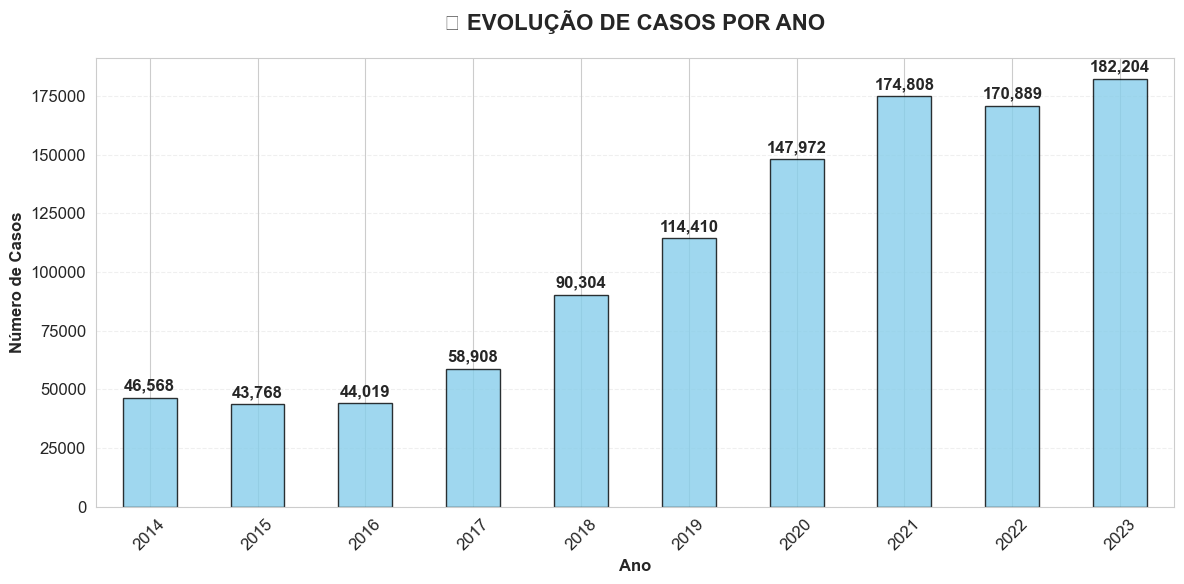


🎯 DISTRIBUIÇÃO DE CASOS POR MÊS (PRIMEIROS 12 REGISTROS):
-----------------------------------------------------------------


,Ano-Mês,Casos,Percentual (%)
0,2014-01,"3,612",0.336%
1,2014-02,"3,947",0.368%
2,2014-03,"4,279",0.398%
3,2014-04,"3,471",0.323%
4,2014-05,"4,598",0.428%
5,2014-06,"3,465",0.323%
6,2014-07,"4,250",0.396%
7,2014-08,"3,830",0.357%
8,2014-09,"3,804",0.354%
9,2014-10,"4,625",0.431%



🎯 ANÁLISE DA MÉDIA MENSAL:
----------------------------------------


,Ano,Média Mensal,Total Anual
0,2014,3880.7,"46,568"
1,2015,3647.3,"43,768"
2,2016,3668.2,"44,019"
3,2017,4909.0,"58,908"
4,2018,7525.3,"90,304"
5,2019,9534.2,"114,410"
6,2020,12331.0,"147,972"
7,2021,14567.3,"174,808"
8,2022,14240.8,"170,889"
9,2023,15183.7,"182,204"


C:\Users\mlzengo\AppData\Local\Temp\ipykernel_22740\2929324322.py:119: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()


📊 Média mensal geral: 8948.8 casos/mês


c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


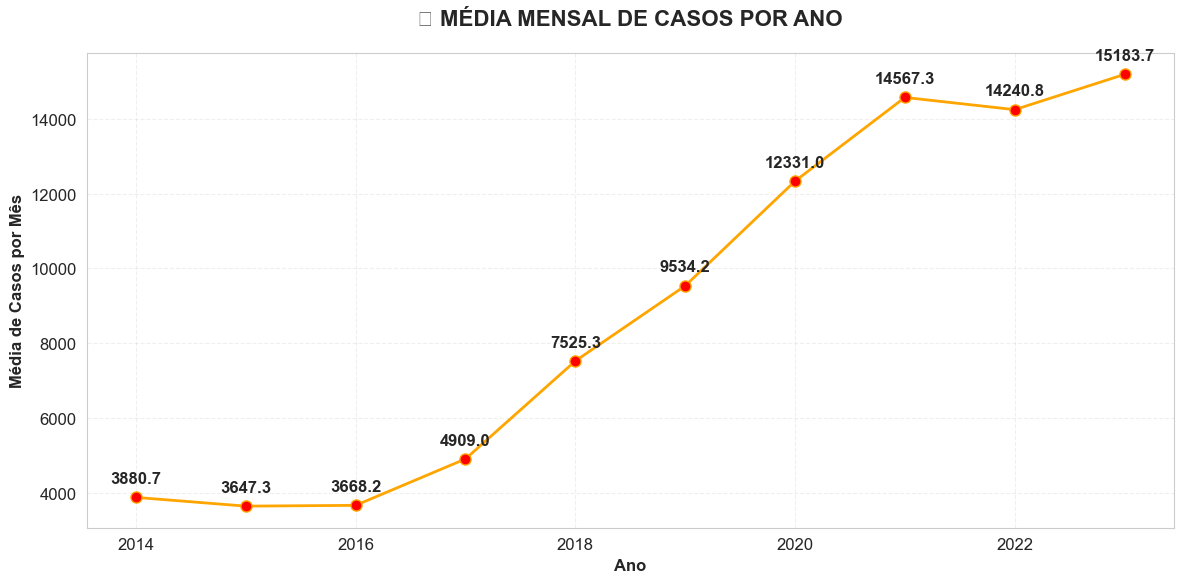

C:\Users\mlzengo\AppData\Local\Temp\ipykernel_22740\2929324322.py:131: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


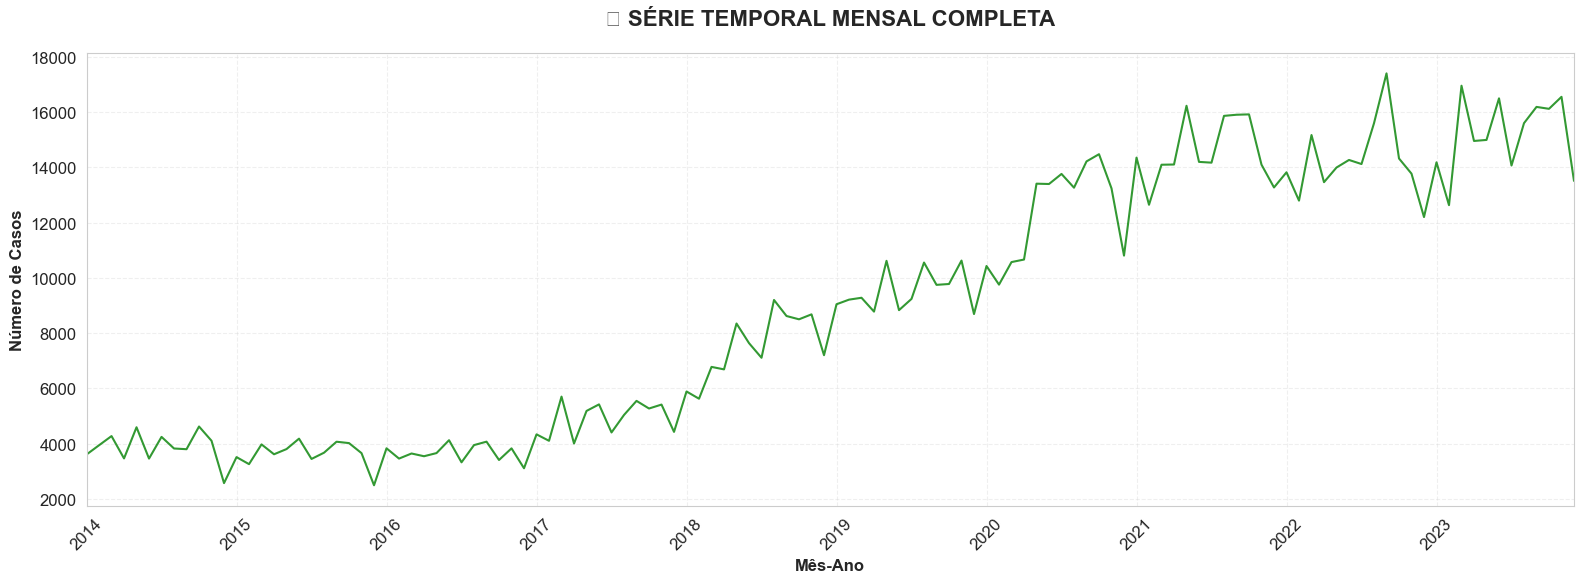


💡 INSIGHTS TEMPORAIS:
   • Ano com mais casos: 2023 (182,204 casos)
   • Ano com menos casos: 2015 (43,768 casos)
   • Média anual: 107385.0 casos/ano
   • Média mensal geral: 8948.8 casos/mês
   • Crescimento no período: 291.3%

🎯 SAZONALIDADE POR MÊS:
------------------------------


,Mês,Casos,Percentual (%)
0,Jan,"83,025",7.73%
1,Fev,"77,451",7.21%
2,Mar,"90,453",8.42%
3,Abr,"83,299",7.76%
4,Mai,"94,837",8.83%
5,Jun,"92,027",8.57%
6,Jul,"87,900",8.19%
7,Ago,"96,569",8.99%
8,Set,"99,568",9.27%
9,Out,"96,439",8.98%


C:\Users\mlzengo\AppData\Local\Temp\ipykernel_22740\2929324322.py:186: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\mlzengo\AppData\Local\Temp\ipykernel_22740\2929324322.py:186: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


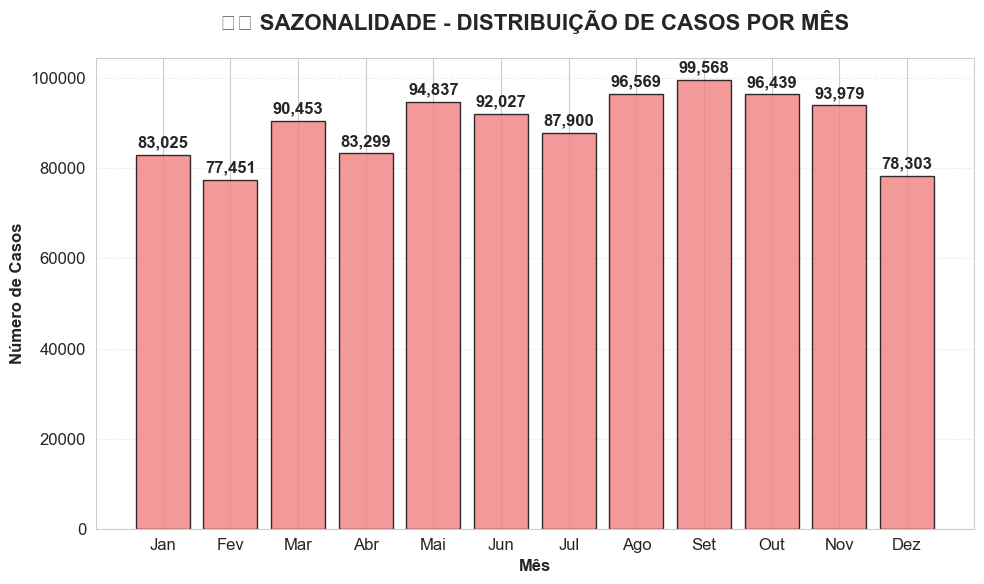

In [8]:
print("\n🎯 " + "="*60)
print("📊 ANÁLISE TEMPORAL COMPLETA - DISTRIBUIÇÃO POR ANO E MÊS")
print("🎯 " + "="*60)

if 'DATA_RECEBIMENTO' in df.columns:
    # Extrair ano e mês
    df['ANO'] = df['DATA_RECEBIMENTO'].dt.year
    df['MES'] = df['DATA_RECEBIMENTO'].dt.month
    df['MES_ANO'] = df['DATA_RECEBIMENTO'].dt.to_period('M')
    
    # Verificar dados nulos
    nulos_temporais = df['ANO'].isnull().sum()
    if nulos_temporais > 0:
        print(f"⚠️  Registros sem data válida: {nulos_temporais} ({nulos_temporais/len(df)*100:.2f}%)")
    
    # Calcular estatísticas
    casos_por_ano = df.groupby('ANO').size()
    casos_por_mes = df.groupby(['ANO', 'MES']).size()
    casos_por_mes_ano = df.groupby('MES_ANO').size()
    
    # Informações gerais
    anos_abrangidos = casos_por_ano.index.tolist()
    print(f"📅 Período analisado: {min(anos_abrangidos)} - {max(anos_abrangidos)}")
    print(f"📈 Total de anos com registros: {len(casos_por_ano)}")
    print(f"📊 Total de meses com registros: {len(casos_por_mes_ano)}")
    
    # Análise por ano - com visualização
    print(f"\n🎯 DISTRIBUIÇÃO DE CASOS POR ANO:")
    print("-" * 50)
    
    # Criar DataFrame formatado para anos
    ano_df = pd.DataFrame({
        'Ano': casos_por_ano.index,
        'Casos': casos_por_ano.values,
        'Percentual (%)': (casos_por_ano.values / len(df) * 100).round(2),
        'Variação Anual (%)': casos_por_ano.pct_change().mul(100).round(2)
    })
    
    display(HTML("<h4 style='color: #2E86AB;'>📅 EVOLUÇÃO ANUAL DE CASOS</h4>"))
    display(ano_df.style.format({
        'Casos': '{:,}',
        'Percentual (%)': '{:.2f}%',
        'Variação Anual (%)': '{:.2f}%'
    }).highlight_max(subset=['Casos'], color='#90EE90')
    .highlight_min(subset=['Casos'], color='#FFCCCB')
    .set_properties(**{'background-color': '#f8f9fa', 'color': '#2c3e50'}))
    
    # Gráfico de evolução anual
    plt.figure(figsize=(12, 6))
    casos_por_ano.plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.8)
    plt.title('📈 EVOLUÇÃO DE CASOS POR ANO', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Ano', fontsize=12, fontweight='bold')
    plt.ylabel('Número de Casos', fontsize=12, fontweight='bold')
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Adicionar valores nas barras
    for i, valor in enumerate(casos_por_ano.values):
        plt.text(i, valor + max(casos_por_ano.values)*0.01, f'{valor:,}', 
                ha='center', va='bottom', fontweight='bold')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Análise por mês - primeiros registros
    print(f"\n🎯 DISTRIBUIÇÃO DE CASOS POR MÊS (PRIMEIROS 12 REGISTROS):")
    print("-" * 65)
    
    # Criar DataFrame formatado para meses
    mes_df = pd.DataFrame({
        'Ano-Mês': [f"{ano}-{mes:02d}" for ano, mes in casos_por_mes.head(12).index],
        'Casos': casos_por_mes.head(12).values,
        'Percentual (%)': (casos_por_mes.head(12).values / len(df) * 100).round(3)
    })
    
    display(HTML("<h4 style='color: #2E86AB;'>📆 DISTRIBUIÇÃO MENSAL (AMOSTRA)</h4>"))
    display(mes_df.style.format({
        'Casos': '{:,}',
        'Percentual (%)': '{:.3f}%'
    }).set_properties(**{'background-color': '#f8f9fa', 'color': '#2c3e50'}))
    
    # MÉDIA MENSAL DE CASOS
    print(f"\n🎯 ANÁLISE DA MÉDIA MENSAL:")
    print("-" * 40)
    
    # Calcular média mensal por ano
    media_mensal_por_ano = df.groupby('ANO')['MES'].count() / 12
    media_mensal_geral = len(df) / (len(casos_por_mes_ano) if len(casos_por_mes_ano) > 0 else 1)
    
    media_mensal_df = pd.DataFrame({
        'Ano': media_mensal_por_ano.index,
        'Média Mensal': media_mensal_por_ano.values.round(1),
        'Total Anual': casos_por_ano.values
    })
    
    display(HTML("<h4 style='color: #2E86AB;'>📊 MÉDIA MENSAL DE CASOS POR ANO</h4>"))
    display(media_mensal_df.style.format({
        'Média Mensal': '{:.1f}',
        'Total Anual': '{:,}'
    }).highlight_max(subset=['Média Mensal'], color='#90EE90')
    .highlight_min(subset=['Média Mensal'], color='#FFCCCB'))
    
    print(f"📊 Média mensal geral: {media_mensal_geral:.1f} casos/mês")
    
    # Gráfico da média mensal por ano
    plt.figure(figsize=(12, 6))
    media_mensal_por_ano.plot(kind='line', marker='o', linewidth=2, markersize=8, 
                             color='orange', markerfacecolor='red')
    plt.title('📈 MÉDIA MENSAL DE CASOS POR ANO', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Ano', fontsize=12, fontweight='bold')
    plt.ylabel('Média de Casos por Mês', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Adicionar valores nos pontos
    for ano, valor in media_mensal_por_ano.items():
        plt.text(ano, valor + max(media_mensal_por_ano.values)*0.02, f'{valor:.1f}', 
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Gráfico de série temporal mensal completa
    if len(casos_por_mes_ano) > 0:
        plt.figure(figsize=(16, 6))
        casos_por_mes_ano.plot(kind='line', color='green', linewidth=1.5, alpha=0.8)
        plt.title('📈 SÉRIE TEMPORAL MENSAL COMPLETA', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Mês-Ano', fontsize=12, fontweight='bold')
        plt.ylabel('Número de Casos', fontsize=12, fontweight='bold')
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    # Estatísticas adicionais
    print(f"\n💡 INSIGHTS TEMPORAIS:")
    print(f"   • Ano com mais casos: {casos_por_ano.idxmax()} ({casos_por_ano.max():,} casos)")
    print(f"   • Ano com menos casos: {casos_por_ano.idxmin()} ({casos_por_ano.min():,} casos)")
    print(f"   • Média anual: {casos_por_ano.mean():.1f} casos/ano")
    print(f"   • Média mensal geral: {media_mensal_geral:.1f} casos/mês")
    
    # Verificar sazonalidade
    if len(casos_por_ano) > 1:
        crescimento = ((casos_por_ano.iloc[-1] - casos_por_ano.iloc[0]) / casos_por_ano.iloc[0] * 100)
        print(f"   • Crescimento no período: {crescimento:.1f}%")
    
    # Verificar completude temporal
    meses_esperados = len(casos_por_ano) * 12
    meses_reais = len(casos_por_mes_ano)
    if meses_reais < meses_esperados:
        print(f"   ⚠️  Dados incompletos: {meses_esperados - meses_reais} meses faltantes")
    
    # Análise sazonal por mês (independente do ano)
    casos_por_mes_agrupado = df.groupby('MES').size()
    print(f"\n🎯 SAZONALIDADE POR MÊS:")
    print("-" * 30)
    
    meses_nomes = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 
                   'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
    
    sazonalidade_df = pd.DataFrame({
        'Mês': [meses_nomes[i-1] for i in casos_por_mes_agrupado.index],
        'Casos': casos_por_mes_agrupado.values,
        'Percentual (%)': (casos_por_mes_agrupado.values / len(df) * 100).round(2)
    })
    
    display(HTML("<h4 style='color: #2E86AB;'>🌡️ DISTRIBUIÇÃO SAZONAL POR MÊS</h4>"))
    display(sazonalidade_df.style.format({
        'Casos': '{:,}',
        'Percentual (%)': '{:.2f}%'
    }).highlight_max(subset=['Casos'], color='#90EE90')
    .highlight_min(subset=['Casos'], color='#FFCCCB'))
    
    # Gráfico de sazonalidade
    plt.figure(figsize=(10, 6))
    plt.bar(sazonalidade_df['Mês'], sazonalidade_df['Casos'], 
            color='lightcoral', edgecolor='black', alpha=0.8)
    plt.title('🌡️ SAZONALIDADE - DISTRIBUIÇÃO DE CASOS POR MÊS', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Mês', fontsize=12, fontweight='bold')
    plt.ylabel('Número de Casos', fontsize=12, fontweight='bold')
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    for i, valor in enumerate(sazonalidade_df['Casos']):
        plt.text(i, valor + max(sazonalidade_df['Casos'])*0.01, f'{valor:,}', 
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ COLUNA 'DATA_RECEBIMENTO' NÃO ENCONTRADA!")
    print("   Verifique se a coluna existe ou se foi convertida para datetime.")

In [9]:
print("\n" + "="*60)
print("📊 ANÁLISE TEMPORAL INICIAL")
print("="*60)

if 'DATA_RECEBIMENTO' in df.columns:
    df['ANO'] = df['DATA_RECEBIMENTO'].dt.year
    df['MES'] = df['DATA_RECEBIMENTO'].dt.month

    casos_por_ano = df.groupby('ANO').size()
    casos_por_mes = df.groupby(['ANO','MES']).size()

    print("Casos por Ano:")
    print(casos_por_ano)

    print("\nCasos por Mês (primeiros registros):")
    print(casos_por_mes.head(12))



📊 ANÁLISE TEMPORAL INICIAL
Casos por Ano:
ANO
2014     46568
2015     43768
2016     44019
2017     58908
2018     90304
2019    114410
2020    147972
2021    174808
2022    170889
2023    182204
dtype: int64

Casos por Mês (primeiros registros):
ANO   MES
2014  1      3612
      2      3947
      3      4279
      4      3471
      5      4598
      6      3465
      7      4250
      8      3830
      9      3804
      10     4625
      11     4109
      12     2578
dtype: int64


In [10]:
print("\n" + "="*60)
print("🔎 QUALIDADE DAS DATAS")
print("="*60)

if 'DATA_RECEBIMENTO' in df.columns:
    print(f"Menor data: {df['DATA_RECEBIMENTO'].min()}")
    print(f"Maior data: {df['DATA_RECEBIMENTO'].max()}")

    # Verificar possíveis datas futuras
    futuros = df[df['DATA_RECEBIMENTO'] > pd.Timestamp.today()]
    if not futuros.empty:
        print(f"⚠️ Existem {len(futuros)} registros com datas futuras!")
    else:
        print("✅ Nenhuma data futura encontrada.")



🔎 QUALIDADE DAS DATAS
Menor data: 2014-01-02 00:00:00
Maior data: 2023-12-31 00:00:00
✅ Nenhuma data futura encontrada.


🚀 INICIANDO ANÁLISE DE SEGMENTOS

🎯 ============================================================
📈 ANÁLISE DA COLUNA SIMPLES: 'CLASSE'
🎯 ============================================================
🔢 Número de categorias únicas: 214
⚠️  Valores nulos: 36714 (3.42%)
📊 As 20 categorias principais representam 90.15% de todos os casos.


C:\Users\mlzengo\AppData\Local\Temp\ipykernel_22740\3712673440.py:46: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


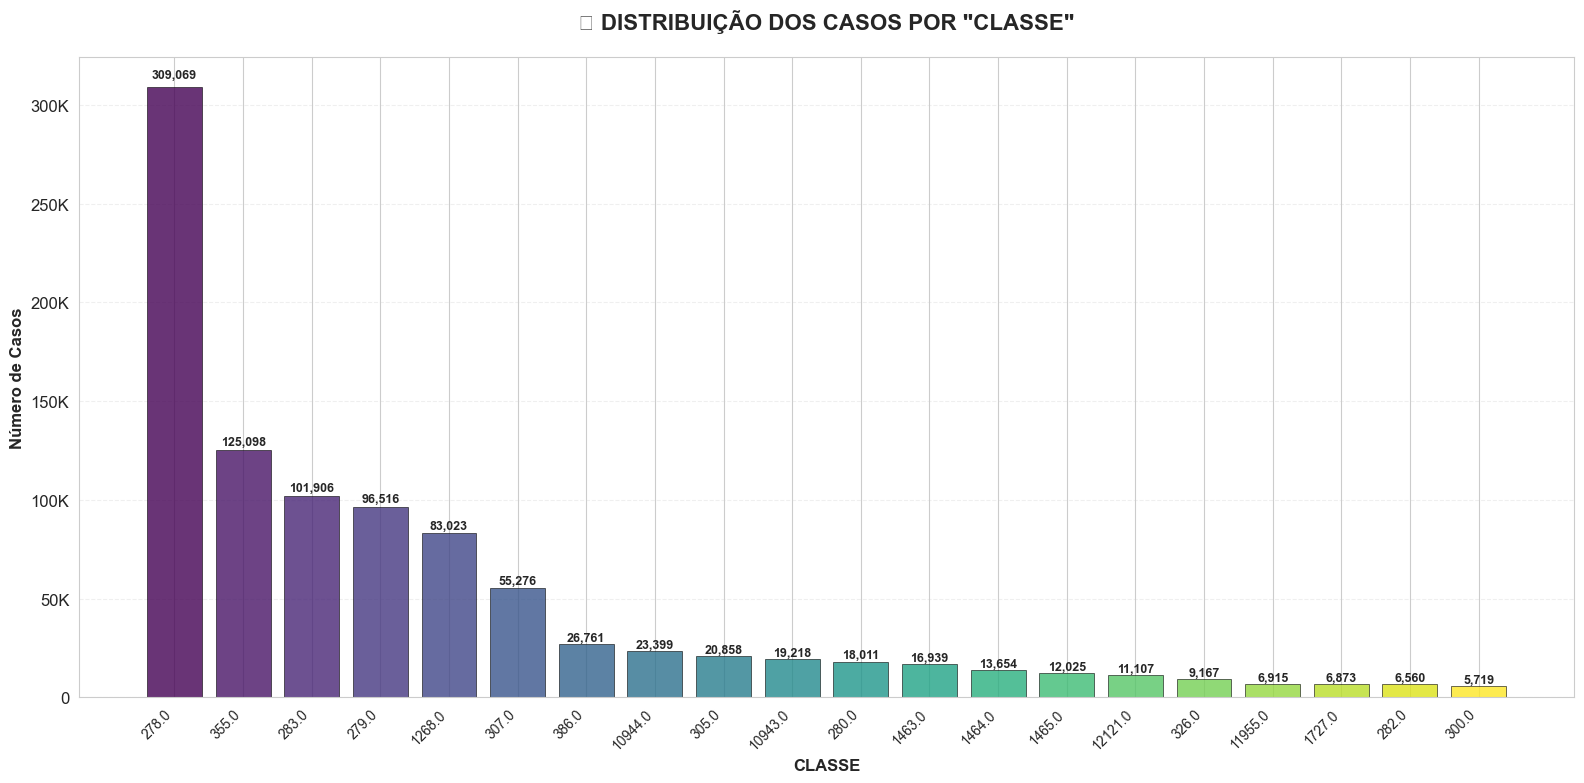

,Categoria,Contagem,Percentual (%)
0,278.0,309069,28.78
1,355.0,125098,11.65
2,283.0,101906,9.49
3,279.0,96516,8.99
4,1268.0,83023,7.73
5,307.0,55276,5.15
6,386.0,26761,2.49
7,10944.0,23399,2.18
8,305.0,20858,1.94
9,10943.0,19218,1.79



💡 RESUMO ESTATÍSTICO:
   • Categoria mais frequente: '278.0' (309,069 casos)
   • Representatividade da categoria principal: 28.78%

🎯 ============================================================
📈 ANÁLISE DA COLUNA DE LISTAS: 'ASSUNTOS'
🎯 ============================================================
🔢 Número de itens únicos: 18127
📊 Os 20 itens principais representam 51.15% de todas as ocorrências de itens.


C:\Users\mlzengo\AppData\Local\Temp\ipykernel_22740\3712673440.py:105: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


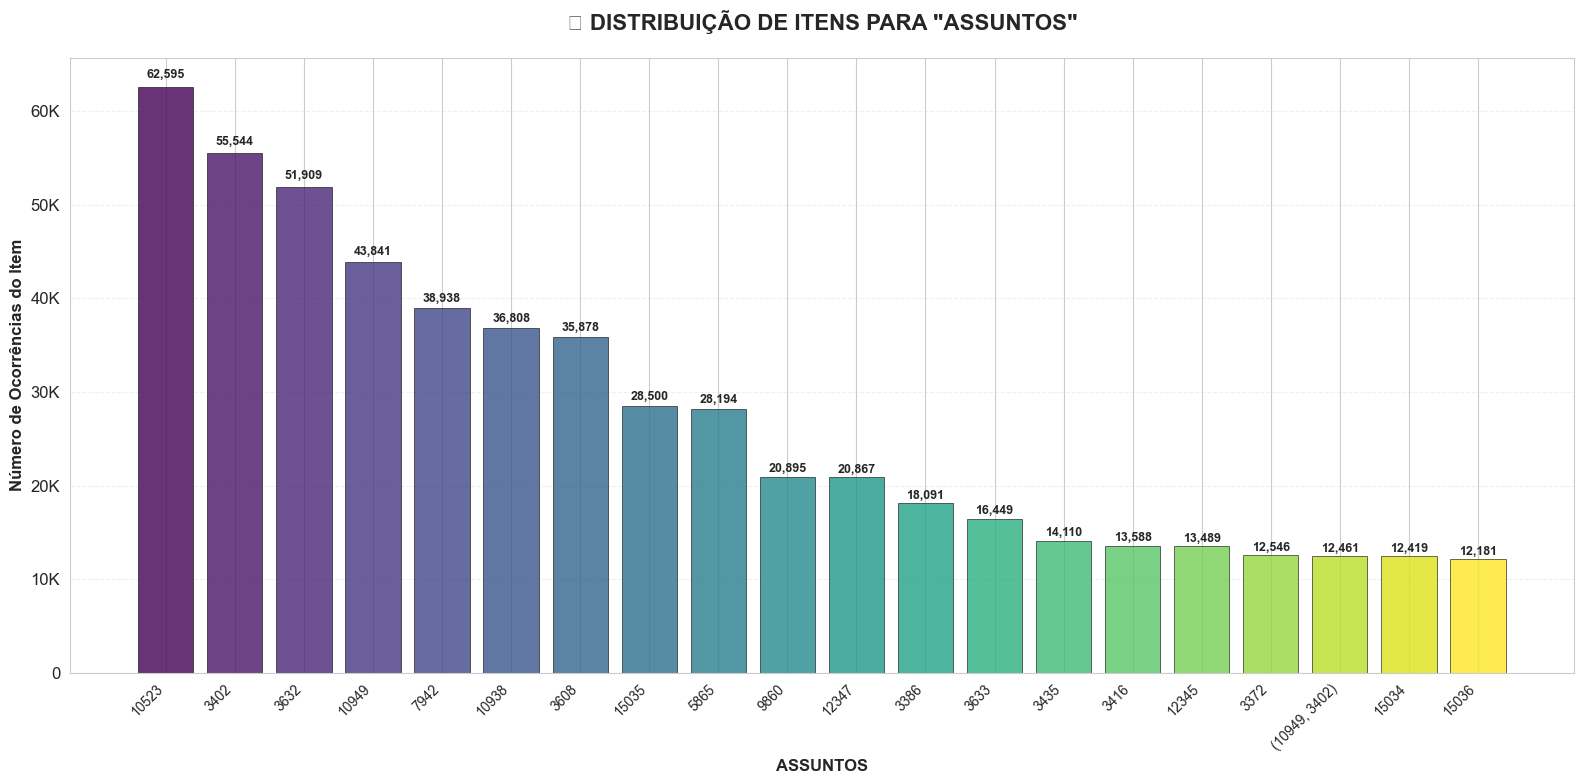

,Item,Contagem,Percentual (%)
0,10523,62595,5.83
1,3402,55544,5.17
2,3632,51909,4.83
3,10949,43841,4.08
4,7942,38938,3.63
5,10938,36808,3.43
6,3608,35878,3.34
7,15035,28500,2.65
8,5865,28194,2.63
9,9860,20895,1.95



💡 RESUMO ESTATÍSTICO:
   • Item mais frequente: '10523' (62,595 ocorrências)
   • Representatividade do item principal: 5.83%

🎯 ============================================================
📈 ANÁLISE DA COLUNA DE LISTAS: 'CNJ_ASSUNTO'
🎯 ============================================================
🔢 Número de itens únicos: 16782
📊 Os 20 itens principais representam 54.79% de todas as ocorrências de itens.


C:\Users\mlzengo\AppData\Local\Temp\ipykernel_22740\3712673440.py:105: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


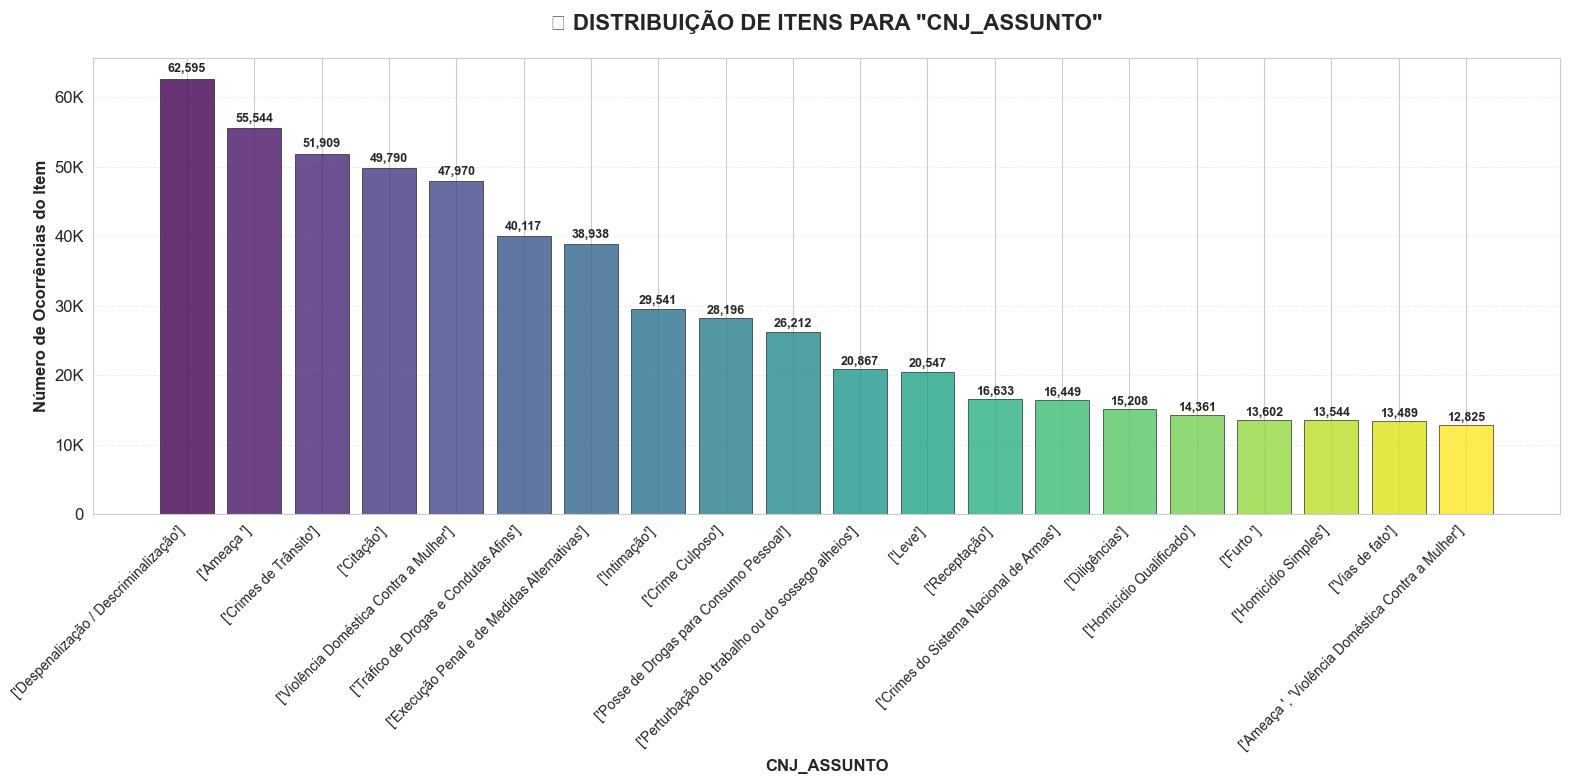

,Item,Contagem,Percentual (%)
0,['Despenalização / Descriminalização'],62595,5.83
1,['Ameaça '],55544,5.17
2,['Crimes de Trânsito'],51909,4.83
3,['Citação'],49790,4.64
4,['Violência Doméstica Contra a Mulher'],47970,4.47
5,['Tráfico de Drogas e Condutas Afins'],40117,3.74
6,['Execução Penal e de Medidas Alternativas'],38938,3.63
7,['Intimação'],29541,2.75
8,['Crime Culposo'],28196,2.63
9,['Posse de Drogas para Consumo Pessoal'],26212,2.44



💡 RESUMO ESTATÍSTICO:
   • Item mais frequente: '['Despenalização / Descriminalização']' (62,595 ocorrências)
   • Representatividade do item principal: 5.83%


In [11]:


# --- FUNÇÃO PARA COLUNAS CATEGÓRICAS SIMPLES (Inalterada) ---
def analisar_segmento_simples(df, coluna, top_n=30):
    # (Seu código original para colunas simples vai aqui, sem nenhuma alteração)
    print(f"\n🎯 {'='*60}")
    print(f"📈 ANÁLISE DA COLUNA SIMPLES: '{coluna.upper()}'")
    print(f"🎯 {'='*60}")
    
    if coluna not in df.columns:
        print(f"❌ ERRO: Coluna '{coluna}' não encontrada no DataFrame!")
        return None
    
    num_unicos = df[coluna].nunique()
    print(f"🔢 Número de categorias únicas: {num_unicos}")
    
    # ... (o resto da sua função continua igual)
    nulos = df[coluna].isnull().sum()
    if nulos > 0:
        print(f"⚠️  Valores nulos: {nulos} ({nulos/len(df)*100:.2f}%)")
    
    contagem = df[coluna].value_counts()
    porc_top_n = (contagem.head(top_n).sum() / len(df)) * 100
    print(f"📊 As {top_n} categorias principais representam {porc_top_n:.2f}% de todos os casos.")
    
    plt.figure(figsize=(16, 8))
    cores = plt.cm.viridis(np.linspace(0, 1, top_n))
    bars = plt.bar(range(top_n), contagem.head(top_n).values, color=cores, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    plt.title(f'📋 DISTRIBUIÇÃO DOS CASOS POR "{coluna.upper()}"', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Número de Casos', fontsize=12, fontweight='bold')
    plt.xlabel(coluna, fontsize=12, fontweight='bold')
    plt.xticks(range(top_n), contagem.head(top_n).index, rotation=45, ha='right', fontsize=10)
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{height:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    def formatar_valores(x, pos):
        if x >= 1_000_000: return f'{x/1_000_000:.1f}M'
        elif x >= 1_000: return f'{x/1_000:.0f}K'
        else: return f'{int(x)}'
    
    plt.gca().yaxis.set_major_formatter(FuncFormatter(formatar_valores))
    plt.tight_layout()
    plt.show()
    
    display(HTML(f"<h4 style='color: #2E86AB;'>📋 TOP {top_n} CATEGORIAS - {coluna.upper()}</h4>"))
    tabela_resultados = pd.DataFrame({
        'Categoria': contagem.head(top_n).index,
        'Contagem': contagem.head(top_n).values,
        'Percentual (%)': (contagem.head(top_n).values / len(df) * 100).round(2)
    })
    display(tabela_resultados)
    
    print(f"\n💡 RESUMO ESTATÍSTICO:")
    print(f"   • Categoria mais frequente: '{contagem.index[0]}' ({contagem.values[0]:,} casos)")
    print(f"   • Representatividade da categoria principal: {contagem.values[0]/len(df)*100:.2f}%")
    return contagem

# --- NOVA FUNÇÃO PARA COLUNAS COM LISTAS (Inalterada) ---
def analisar_segmento_lista(df, coluna, top_n=30):
    # (A função que usa .explode() continua igual à anterior)
    print(f"\n🎯 {'='*60}")
    print(f"📈 ANÁLISE DA COLUNA DE LISTAS: '{coluna.upper()}'")
    print(f"🎯 {'='*60}")
    
    if coluna not in df.columns:
        print(f"❌ ERRO: Coluna '{coluna}' não encontrada no DataFrame!")
        return None
    
    exploded_series = df[coluna].explode().dropna()
    
    num_unicos = exploded_series.nunique()
    print(f"🔢 Número de itens únicos: {num_unicos}")
    
    # ... (o resto da função continua igual)
    contagem = exploded_series.value_counts()
    porc_top_n = (contagem.head(top_n).sum() / len(exploded_series)) * 100
    print(f"📊 Os {top_n} itens principais representam {porc_top_n:.2f}% de todas as ocorrências de itens.")
    
    plt.figure(figsize=(16, 8))
    cores = plt.cm.viridis(np.linspace(0, 1, top_n))
    bars = plt.bar(range(top_n), contagem.head(top_n).values, color=cores, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    plt.title(f'📋 DISTRIBUIÇÃO DE ITENS PARA "{coluna.upper()}"', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Número de Ocorrências do Item', fontsize=12, fontweight='bold')
    plt.xlabel(coluna, fontsize=12, fontweight='bold')
    plt.xticks(range(top_n), contagem.head(top_n).index, rotation=45, ha='right', fontsize=10)
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{height:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    def formatar_valores(x, pos):
        if x >= 1_000_000: return f'{x/1_000_000:.1f}M'
        elif x >= 1_000: return f'{x/1_000:.0f}K'
        else: return f'{int(x)}'
        
    plt.gca().yaxis.set_major_formatter(FuncFormatter(formatar_valores))
    plt.tight_layout()
    plt.show()
    
    display(HTML(f"<h4 style='color: #2E86AB;'>📋 TOP {top_n} ITENS - {coluna.upper()}</h4>"))
    tabela_resultados = pd.DataFrame({
        'Item': contagem.head(top_n).index,
        'Contagem': contagem.head(top_n).values,
        'Percentual (%)': (contagem.head(top_n).values / len(exploded_series) * 100).round(2)
    })
    display(tabela_resultados)

    print(f"\n💡 RESUMO ESTATÍSTICO:")
    print(f"   • Item mais frequente: '{contagem.index[0]}' ({contagem.values[0]:,} ocorrências)")
    print(f"   • Representatividade do item principal: {contagem.values[0]/len(exploded_series)*100:.2f}%")
    return contagem

# --- FUNÇÃO PRINCIPAL CORRIGIDA E MAIS ROBUSTA ---
def analisar_coluna(df, coluna, top_n=30):
    """
    Analisa uma coluna do DataFrame, decidindo qual função usar
    com base em uma lista explícita de colunas que contêm listas.
    """
    # Lista explícita das colunas que sabemos que contêm listas
    COLUNAS_DE_LISTAS = ['ASSUNTOS', 'CNJ_ASSUNTO', 'PROJUDI_ASSUNTO']
    
    if coluna in COLUNAS_DE_LISTAS:
        # Se a coluna estiver na nossa lista, usa a função para listas
        analisar_segmento_lista(df, coluna, top_n)
    else:
        # Caso contrário, usa a função para categorias simples
        analisar_segmento_simples(df, coluna, top_n)


# ==============================================================================
# --- EXEMPLO DE USO ---
# Agora as chamadas funcionarão corretamente para ambos os casos
# ==============================================================================

print("🚀 INICIANDO ANÁLISE DE SEGMENTOS")
print("=" * 60)

# 1. Análise de uma coluna categórica SIMPLES
analisar_coluna(df, 'CLASSE', top_n=20)

# 2. Análise de uma coluna com LISTAS
analisar_coluna(df, 'ASSUNTOS', top_n=20)

# 3. Análise de outra coluna com LISTAS
analisar_coluna(df, 'CNJ_ASSUNTO', top_n=20)